In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import os
from PIL import Image
data_dir='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'
class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        
        self.image_paths = []
        self.classes=[]
        for sub in os.listdir(root_dir):
            self.classes = list(set(self.classes + [item for item in os.listdir(root_dir + '/' + sub)]))

        for sub in os.listdir(root_dir):
            self.image_paths+=self.get_pathes(root_dir+'/'+sub)
        
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}
        self.transform = transform

    def get_pathes(self, root):
        image_paths = []
        labels = os.listdir(root)

        for label in labels:
            images = os.listdir(os.path.join(root, label))    
            image_paths.extend([os.path.join(root, label, image) for image in images])
        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        label_name = os.path.normpath(image_path).split(os.path.sep)[-2]

        return image, self.class_to_idx[label_name]


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

custom_train_data = ImageDataset(data_dir, transform=train_transform)

custom_train_data[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


dataset1 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0', transform=train_transform)
dataset2 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1', transform=test_transform)
dataset3 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2', transform=test_transform)

concatenated_dataset = ConcatDataset([dataset1, dataset2,dataset3])

len(concatenated_dataset)

10661

In [5]:
concatenated_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [6]:
from torch.utils.data import random_split

train_size = int(0.8 * len(concatenated_dataset))
test_size = len(concatenated_dataset) - train_size

train_dataset, test_dataset = random_split(concatenated_dataset, [train_size, test_size])

train_transform = transforms.Compose([
    transforms.Resize((356, 356)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

train_dataset.transform = train_transform

In [7]:
train_dataset

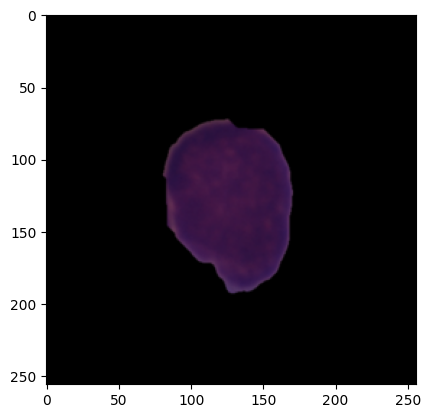

In [8]:
import matplotlib.pyplot as plt

img, label = custom_train_data[0]

# Get the image data (tensor) and convert it back to a NumPy array for manipulation
img = img.numpy()

# Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
img = img.transpose((1, 2, 0))

# Plot the image with a title (including label name)
plt.imshow(img)
plt.show()

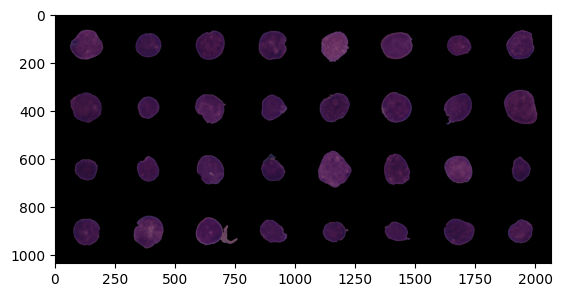

In [9]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0) # результатом є тензор

plt.imshow(grid)
